In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

2.1.2+cpu


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

In [61]:
!pip install networkx


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
import os.path as osp
import networkx as nx
import numpy as np
import torch.nn.functional as F
import pandas as pd
import torch
from torch_geometric.data import Dataset, download_url
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import RandomLinkSplit

In [3]:
df = pd.read_csv("crimes.csv")

In [4]:
df.describe

<bound method NDFrame.describe of                                CATEGORIE        DATE QUART   PDQ  \
0               Vol de véhicule à moteur  2018-09-13  jour  30.0   
1               Vol de véhicule à moteur  2018-04-30  jour  30.0   
2               Vol de véhicule à moteur  2018-09-01  nuit   7.0   
3                                 Méfait  2017-07-21  jour  21.0   
4                                 Méfait  2017-07-29  jour  12.0   
...                                  ...         ...   ...   ...   
278179          Vol de véhicule à moteur  2023-07-14  jour  35.0   
278180                      Introduction  2023-12-17  soir  35.0   
278181                      Introduction  2023-04-11  jour  35.0   
278182  Vol dans / sur véhicule à moteur  2023-05-08  soir  35.0   
278183          Vol de véhicule à moteur  2023-07-31  jour   9.0   

                    X             Y  LONGITUDE   LATITUDE  
0       294904.159001  5.047549e+06 -73.626778  45.567780  
1       294904.159001  5.0475

In [5]:
df_no_nan = df.dropna()

In [6]:
df_no_nan

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
6,Méfait,2017-07-30,jour,38.0,297654.715002,5.041877e+06,-73.591457,45.516776
8,Vol dans / sur véhicule à moteur,2017-08-01,jour,39.0,294259.780993,5.051450e+06,-73.635117,45.602873
...,...,...,...,...,...,...,...,...
278179,Vol de véhicule à moteur,2023-07-14,jour,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278180,Introduction,2023-12-17,soir,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278181,Introduction,2023-04-11,jour,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278182,Vol dans / sur véhicule à moteur,2023-05-08,soir,35.0,297170.030004,5.044145e+06,-73.597696,45.537181


In [7]:
df_no_nan.describe

<bound method NDFrame.describe of                                CATEGORIE        DATE QUART   PDQ  \
0               Vol de véhicule à moteur  2018-09-13  jour  30.0   
1               Vol de véhicule à moteur  2018-04-30  jour  30.0   
2               Vol de véhicule à moteur  2018-09-01  nuit   7.0   
6                                 Méfait  2017-07-30  jour  38.0   
8       Vol dans / sur véhicule à moteur  2017-08-01  jour  39.0   
...                                  ...         ...   ...   ...   
278179          Vol de véhicule à moteur  2023-07-14  jour  35.0   
278180                      Introduction  2023-12-17  soir  35.0   
278181                      Introduction  2023-04-11  jour  35.0   
278182  Vol dans / sur véhicule à moteur  2023-05-08  soir  35.0   
278183          Vol de véhicule à moteur  2023-07-31  jour   9.0   

                    X             Y  LONGITUDE   LATITUDE  
0       294904.159001  5.047549e+06 -73.626778  45.567780  
1       294904.159001  5.0475

In [8]:
df= df_no_nan

In [9]:
df

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
6,Méfait,2017-07-30,jour,38.0,297654.715002,5.041877e+06,-73.591457,45.516776
8,Vol dans / sur véhicule à moteur,2017-08-01,jour,39.0,294259.780993,5.051450e+06,-73.635117,45.602873
...,...,...,...,...,...,...,...,...
278179,Vol de véhicule à moteur,2023-07-14,jour,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278180,Introduction,2023-12-17,soir,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278181,Introduction,2023-04-11,jour,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278182,Vol dans / sur véhicule à moteur,2023-05-08,soir,35.0,297170.030004,5.044145e+06,-73.597696,45.537181


In [10]:
df.drop('QUART', axis=1)

,CATEGORIE,DATE,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
6,Méfait,2017-07-30,38.0,297654.715002,5.041877e+06,-73.591457,45.516776
8,Vol dans / sur véhicule à moteur,2017-08-01,39.0,294259.780993,5.051450e+06,-73.635117,45.602873
...,...,...,...,...,...,...,...
278179,Vol de véhicule à moteur,2023-07-14,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278180,Introduction,2023-12-17,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278181,Introduction,2023-04-11,35.0,297170.030004,5.044145e+06,-73.597696,45.537181
278182,Vol dans / sur véhicule à moteur,2023-05-08,35.0,297170.030004,5.044145e+06,-73.597696,45.537181


In [12]:
df =df.drop('X', axis=1)

In [13]:
df =df.drop('Y', axis=1)

In [14]:
df

,CATEGORIE,DATE,QUART,PDQ,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,-73.685928,45.519122
6,Méfait,2017-07-30,jour,38.0,-73.591457,45.516776
8,Vol dans / sur véhicule à moteur,2017-08-01,jour,39.0,-73.635117,45.602873
...,...,...,...,...,...,...
278179,Vol de véhicule à moteur,2023-07-14,jour,35.0,-73.597696,45.537181
278180,Introduction,2023-12-17,soir,35.0,-73.597696,45.537181
278181,Introduction,2023-04-11,jour,35.0,-73.597696,45.537181
278182,Vol dans / sur véhicule à moteur,2023-05-08,soir,35.0,-73.597696,45.537181


In [15]:
df['CATEGORIE'].unique()

array(['Vol de véhicule à moteur', 'Méfait',
       'Vol dans / sur véhicule à moteur', 'Introduction',
       'Vols qualifiés', 'Infractions entrainant la mort'], dtype=object)

In [16]:
df = df[df['CATEGORIE'] != 'Infractions entrainant la mort']

In [17]:
df['CATEGORIE'].unique()

array(['Vol de véhicule à moteur', 'Méfait',
       'Vol dans / sur véhicule à moteur', 'Introduction',
       'Vols qualifiés'], dtype=object)

In [18]:
df

,CATEGORIE,DATE,QUART,PDQ,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,-73.685928,45.519122
6,Méfait,2017-07-30,jour,38.0,-73.591457,45.516776
8,Vol dans / sur véhicule à moteur,2017-08-01,jour,39.0,-73.635117,45.602873
...,...,...,...,...,...,...
278179,Vol de véhicule à moteur,2023-07-14,jour,35.0,-73.597696,45.537181
278180,Introduction,2023-12-17,soir,35.0,-73.597696,45.537181
278181,Introduction,2023-04-11,jour,35.0,-73.597696,45.537181
278182,Vol dans / sur véhicule à moteur,2023-05-08,soir,35.0,-73.597696,45.537181


In [19]:
for index, row in df.iterrows():
    if row['CATEGORIE'] == 'Vol de véhicule à moteur':
        df.at[index, 'CATEGORIE'] = [1,0,0,0,0]
    if row['CATEGORIE'] == 'Méfait':
        df.at[index, 'CATEGORIE'] = [0,1,0,0,0]
    if row['CATEGORIE'] == 'Vol dans / sur véhicule à moteur':
        df.at[index, 'CATEGORIE'] = [0,0,1,0,0]
    if row['CATEGORIE'] == 'Introduction':
        df.at[index, 'CATEGORIE'] = [0,0,0,1,0]
    if row['CATEGORIE'] == 'Vols qualifiés':
        df.at[index, 'CATEGORIE'] = [0,0,0,0,1]

In [22]:
df

,CATEGORIE,DATE,QUART,PDQ,LONGITUDE,LATITUDE
0,"[1, 0, 0, 0, 0]",2018-09-13,jour,30.0,-73.626778,45.567780
1,"[1, 0, 0, 0, 0]",2018-04-30,jour,30.0,-73.626778,45.567780
2,"[1, 0, 0, 0, 0]",2018-09-01,nuit,7.0,-73.685928,45.519122
6,"[0, 1, 0, 0, 0]",2017-07-30,jour,38.0,-73.591457,45.516776
8,"[0, 0, 1, 0, 0]",2017-08-01,jour,39.0,-73.635117,45.602873
...,...,...,...,...,...,...
278179,"[1, 0, 0, 0, 0]",2023-07-14,jour,35.0,-73.597696,45.537181
278180,"[0, 0, 0, 1, 0]",2023-12-17,soir,35.0,-73.597696,45.537181
278181,"[0, 0, 0, 1, 0]",2023-04-11,jour,35.0,-73.597696,45.537181
278182,"[0, 0, 1, 0, 0]",2023-05-08,soir,35.0,-73.597696,45.537181


In [23]:
df =df.drop(['QUART','PDQ'], axis=1)

In [24]:
df

,CATEGORIE,DATE,LONGITUDE,LATITUDE
0,"[1, 0, 0, 0, 0]",2018-09-13,-73.626778,45.567780
1,"[1, 0, 0, 0, 0]",2018-04-30,-73.626778,45.567780
2,"[1, 0, 0, 0, 0]",2018-09-01,-73.685928,45.519122
6,"[0, 1, 0, 0, 0]",2017-07-30,-73.591457,45.516776
8,"[0, 0, 1, 0, 0]",2017-08-01,-73.635117,45.602873
...,...,...,...,...
278179,"[1, 0, 0, 0, 0]",2023-07-14,-73.597696,45.537181
278180,"[0, 0, 0, 1, 0]",2023-12-17,-73.597696,45.537181
278181,"[0, 0, 0, 1, 0]",2023-04-11,-73.597696,45.537181
278182,"[0, 0, 1, 0, 0]",2023-05-08,-73.597696,45.537181


In [29]:
# Parse date from 'DATE OCC' and ignore the time component
df['date'] = pd.to_datetime(df['DATE']).dt.date



min_date = df['date'].min()
df['time_node'] = (pd.to_datetime(df['date']) - pd.to_datetime(min_date)).dt.days

# Discretize locations based on 'LAT' and 'LON'
df['lat_grid'] = (df['LATITUDE'] / 0.01).round().astype(int)
df['lon_grid'] = (df['LONGITUDE'] / 0.01).round().astype(int)

In [30]:
df

,CATEGORIE,DATE,LONGITUDE,LATITUDE,date,time_node,lat_grid,lon_grid
0,"[1, 0, 0, 0, 0]",2018-09-13,-73.626778,45.567780,2018-09-13,1351,4557,-7363
1,"[1, 0, 0, 0, 0]",2018-04-30,-73.626778,45.567780,2018-04-30,1215,4557,-7363
2,"[1, 0, 0, 0, 0]",2018-09-01,-73.685928,45.519122,2018-09-01,1339,4552,-7369
6,"[0, 1, 0, 0, 0]",2017-07-30,-73.591457,45.516776,2017-07-30,941,4552,-7359
8,"[0, 0, 1, 0, 0]",2017-08-01,-73.635117,45.602873,2017-08-01,943,4560,-7364
...,...,...,...,...,...,...,...,...
278179,"[1, 0, 0, 0, 0]",2023-07-14,-73.597696,45.537181,2023-07-14,3116,4554,-7360
278180,"[0, 0, 0, 1, 0]",2023-12-17,-73.597696,45.537181,2023-12-17,3272,4554,-7360
278181,"[0, 0, 0, 1, 0]",2023-04-11,-73.597696,45.537181,2023-04-11,3022,4554,-7360
278182,"[0, 0, 1, 0, 0]",2023-05-08,-73.597696,45.537181,2023-05-08,3049,4554,-7360


In [69]:
# Map unique time and location nodes to continuous indices
unique_times = df['time_node'].unique()
unique_locations = df['LATITUDE'].astype(str) + ',' + df['LONGITUDE'].astype(str)
unique_locations = unique_locations.unique()

time_node_mapping = {time: i for i, time in enumerate(unique_times)}
location_node_mapping = {loc: i + len(unique_times) for i, loc in enumerate(unique_locations)}

# Total number of nodes
total_nodes = len(unique_times) + len(unique_locations)

# Initialize node features
node_features = np.zeros((total_nodes, 3))

# Assign features to time nodes
for time, index in time_node_mapping.items():
    node_features[index, 0] = time

# Assign features to location nodes
for loc, index in location_node_mapping.items():
    lat, lon = map(float, loc.split(','))
    node_features[index, 1:3] = [lat, lon]

# Convert to tensor
node_features = torch.tensor(node_features, dtype=torch.float)

# Create edge index
edge_start = df.apply(lambda row: time_node_mapping[row['time_node']], axis=1)
edge_end = df.apply(lambda row: location_node_mapping[f"{row['LATITUDE']},{row['LONGITUDE']}"], axis=1)

edge_index = torch.tensor([edge_start.values, edge_end.values], dtype=torch.long)

# Create the data object
data = Data(x=node_features, edge_index=edge_index)
print(data)

Data(x=[22119, 3], edge_index=[2, 231075])


In [107]:
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)
print(train_data, val_data, test_data)
print(train_data.edge_index, train_data.edge_label, train_data.edge_label_index)

Data(x=[22119, 3], edge_index=[2, 323506], edge_label=[323506], edge_label_index=[2, 323506]) Data(x=[22119, 3], edge_index=[2, 323506], edge_label=[46214], edge_label_index=[2, 46214]) Data(x=[22119, 3], edge_index=[2, 369720], edge_label=[92430], edge_label_index=[2, 92430])
tensor([[ 2010,    82,   390,  ...,  8586,  9118, 14319],
        [10080, 16817, 12653,  ...,  3238,  1689,  3291]]) tensor([1., 1., 1.,  ..., 0., 0., 0.]) tensor([[ 2010,    82,   390,  ...,  7599,  6304, 18116],
        [10080, 16817, 12653,  ..., 14448,  2828, 16223]])


In [108]:
class ComplexGCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(ComplexGCNNet, self).__init__()
        # Existing GCN and BatchNorm layers
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.bn3 = torch.nn.BatchNorm1d(out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Additional fully connected layers
        self.fc1 = torch.nn.Linear(out_channels * 2, hidden_channels)  # Assuming concatenation of features
        self.fc2 = torch.nn.Linear(hidden_channels, 1)  # Single unit for binary classification

    def forward(self, x, edge_index):
        # Node-level feature processing
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index))

        # Edge-level prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)

        # Pass through the fully connected layers
        edge_features = F.relu(self.fc1(edge_features))
        out = torch.sigmoid(self.fc2(edge_features).view(-1))
        return out

# Initialize the model
model = ComplexGCNNet(in_channels=3, hidden_channels=64, out_channels=32, dropout_rate=0.5)


In [109]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


[{'target_longitude': 45.51986312866211, 'target_latitude': -73.52861785888672}]
torch.Size([92430])
torch.Size([92430])
tensor([1.0000e+00, 9.9999e-01, 1.0000e+00,  ..., 3.0242e-05, 1.0000e+00,
        1.0000e+00]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Epoch [1/100], Loss: 0.6852, Train Accuracy: 0.5691
Epoch [2/100], Loss: 0.6505, Train Accuracy: 0.6807
Epoch [3/100], Loss: 0.6216, Train Accuracy: 0.7513
Epoch [4/100], Loss: 0.5949, Train Accuracy: 0.7820
Epoch [5/100], Loss: 0.5743, Train Accuracy: 0.7910
Epoch [6/100], Loss: 0.5531, Train Accuracy: 0.7975
Epoch [7/100], Loss: 0.5339, Train Accuracy: 0.8000
Epoch [8/100], Loss: 0.5186, Train Accuracy: 0.8002
Epoch [9/100], Loss: 0.5055, Train Accuracy: 0.8027
Epoch [10/100], Loss: 0.4948, Train Accuracy: 0.8027
Epoch [11/100], Loss: 0.4863, Train Accuracy: 0.8042
Epoch [12/100], Loss: 0.4793, Train Accuracy: 0.8057
Epoch [13/100], Loss: 0.4730, Train Accuracy: 0.8068
Epoch [14/100], Loss: 0.4665, Train Accuracy: 0.8095
Epoch [15/10

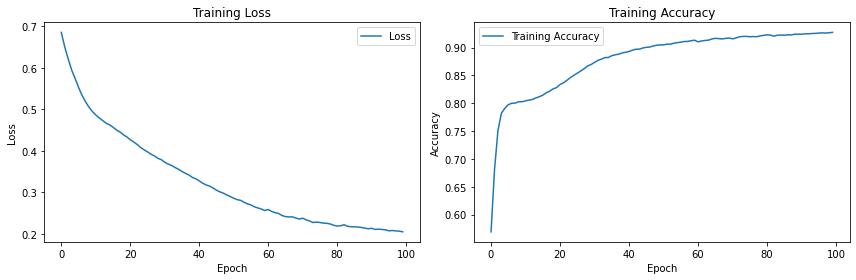

In [110]:
import matplotlib.pyplot as plt

def train(model, data, optimizer, num_epochs):
    loss_values = []  # To collect loss values for plotting
    train_accuracy_values = []  # To collect training accuracy values for plotting

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        pred = model(data.x, data.edge_label_index)
        labels = data.edge_label

        # Calculate loss
        loss = F.binary_cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        threshold = 0.5  # Adjust the threshold as needed
        preds = (pred >= threshold).float()
        correct = (preds == labels).sum().item()
        train_accuracy = correct / len(labels)

        # Print training accuracy
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}')

        # Collect loss and accuracy values
        loss_values.append(loss.item())
        train_accuracy_values.append(train_accuracy)

    # Plot loss and training accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_values, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
num_epochs = 100 # Adjust as needed
test(model, test_data)
train(model, train_data, optimizer, num_epochs)


In [111]:
import networkx as nx
def test(model, data):
    model.eval()

    with torch.no_grad():
        # Forward pass
        pred = model(data.x, data.edge_label_index)
        labels = data.edge_label
        edge_start = data.edge_label_index[0]
        edge_end = data.edge_label_index[1]
        source_node_features = data.x[edge_start]
        target_node_features = data.x[edge_end]
        
        
        predicted_data = []
        for i in range(len(pred)):
            source_longitude = source_node_features[i, 1].item()
            source_latitude = source_node_features[i, 2].item()
            target_longitude = target_node_features[i, 1].item()
            target_latitude = target_node_features[i, 2].item()
            
        if pred[i] == 1:
            predicted_data.append({'source_longitude': source_longitude, 'source_latitude': source_latitude})
        else:
            predicted_data.append({'target_longitude': target_longitude, 'target_latitude': target_latitude})

        print(predicted_data)
        print(pred.size())
        print(labels.size())
        print(pred, labels)
        
      

        # Calculate accuracy
        threshold = 0.5  # Adjust the threshold as needed
        preds = (pred >= threshold).float()
        correct = (preds == labels).sum().item()

        # Only consider the test edges for evaluation
        test_edge_count = len(data.edge_label)
        accuracy = correct / test_edge_count

    return accuracy

# Test the model on the test data
test_accuracy = test(model, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')

[{'target_longitude': 45.51986312866211, 'target_latitude': -73.52861785888672}]
torch.Size([92430])
torch.Size([92430])
tensor([0.9438, 0.7909, 0.8332,  ..., 0.0026, 0.0114, 0.9289]) tensor([1., 1., 1.,  ..., 0., 0., 0.])
Test Accuracy: 0.9210
